In [1]:
cd ..

/home/abhishekabhishek/git/UnsupGenModbyMPS


In [41]:
%load_ext autoreload

import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp

from MPScumulant import MPS_c
import mps_circuit_helpers
import mps_circuit
import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and visualize the dataset

(30, 4, 4) bool


(<Figure size 1296x1080 with 30 Axes>, <Axes: >)

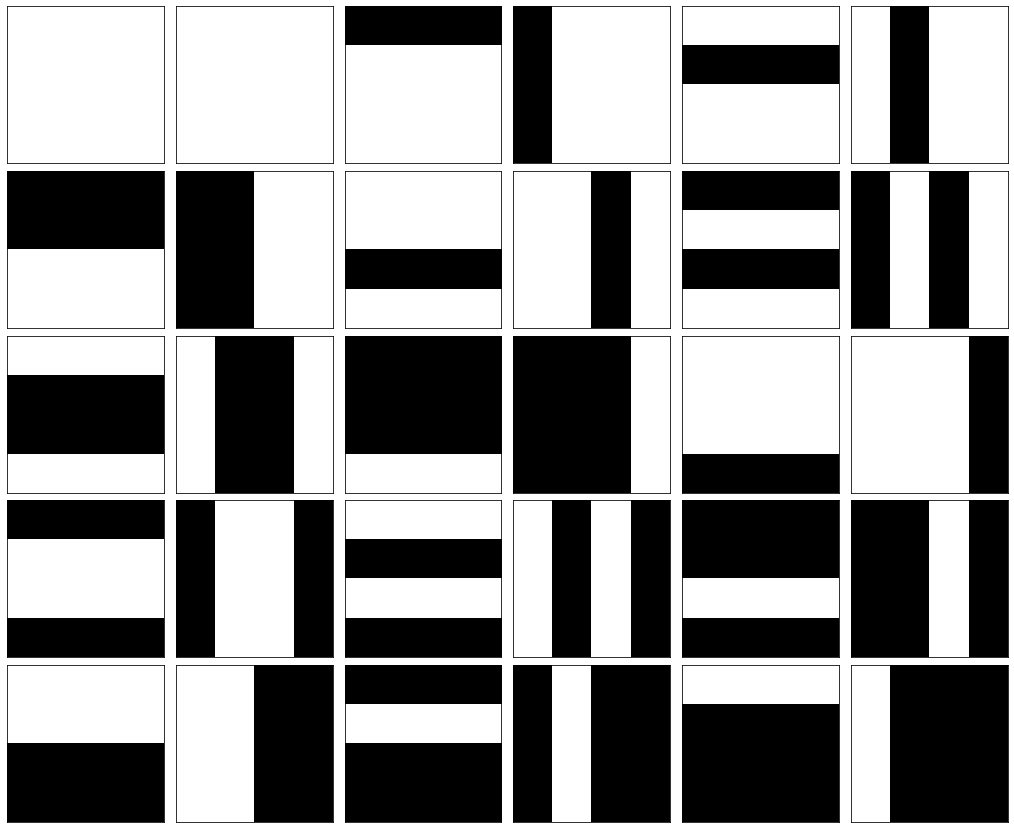

In [7]:
%autoreload
data = np.load('BStest/BSdata.npy')
print(data.shape, data.dtype)

# convert bool data to int
data = data.astype(np.int32)

metrics.plot_BAS(data)

# Load the trained MPS

In [8]:
%autoreload
m = MPS_c(16, max_bond_dim=300)
m.loadMPS('BS-MPS')

# check the properties of the matrices in the MPS
print("core tensor index, shape")
for i in range(len(m.matrices)):
    tn_core = m.matrices[i]
    print(i, tn_core.shape)

core tensor index, shape
0 (1, 2, 2)
1 (2, 2, 4)
2 (4, 2, 8)
3 (8, 2, 15)
4 (15, 2, 16)
5 (16, 2, 16)
6 (16, 2, 16)
7 (16, 2, 15)
8 (15, 2, 16)
9 (16, 2, 16)
10 (16, 2, 16)
11 (16, 2, 15)
12 (15, 2, 8)
13 (8, 2, 4)
14 (4, 2, 2)
15 (2, 2, 1)


![mps.png](../figures/trained-mps.png)

## Check the normalization of the MPS

In [20]:
mps_circuit_helpers.are_isometries(m)

idx, core tensor shape, left isometry, right isometry
0 (1, 2, 2) True True
1 (2, 2, 4) True True
2 (4, 2, 8) True True
3 (8, 2, 15) True False
4 (15, 2, 16) True False
5 (16, 2, 16) True False
6 (16, 2, 16) True False
7 (16, 2, 15) True False
8 (15, 2, 16) True False
9 (16, 2, 16) True False
10 (16, 2, 16) True False
11 (16, 2, 15) True False
12 (15, 2, 8) True False
13 (8, 2, 4) True False
14 (4, 2, 2) True False
15 (2, 2, 1) True False


We can see that some of the tensors are already isometries but not all.

In [21]:
%autoreload
mps_unitaries = mps_circuit_helpers.get_mps_unitaries(m)

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 4), 2
i = 2, (4, 2, 8), 4
i = 3, (8, 2, 16), 8
i = 4, (16, 2, 16), 16
i = 5, (16, 2, 16), 16
i = 6, (16, 2, 16), 16
i = 7, (16, 2, 16), 16
i = 8, (16, 2, 16), 16
i = 9, (16, 2, 16), 16
i = 10, (16, 2, 16), 16
i = 11, (16, 2, 16), 16
i = 12, (16, 2, 8), 16
i = 13, (8, 2, 4), 8
i = 14, (4, 2, 2), 4
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14


In [25]:
print(f"Total no. of multi-qubit unitaries {len(mps_unitaries)}")

Total no. of multi-qubit unitaries 15


# Create the MPS-to-PQC quantum circuit

(<Figure size 1296x1224 with 1 Axes>, <Axes: >)

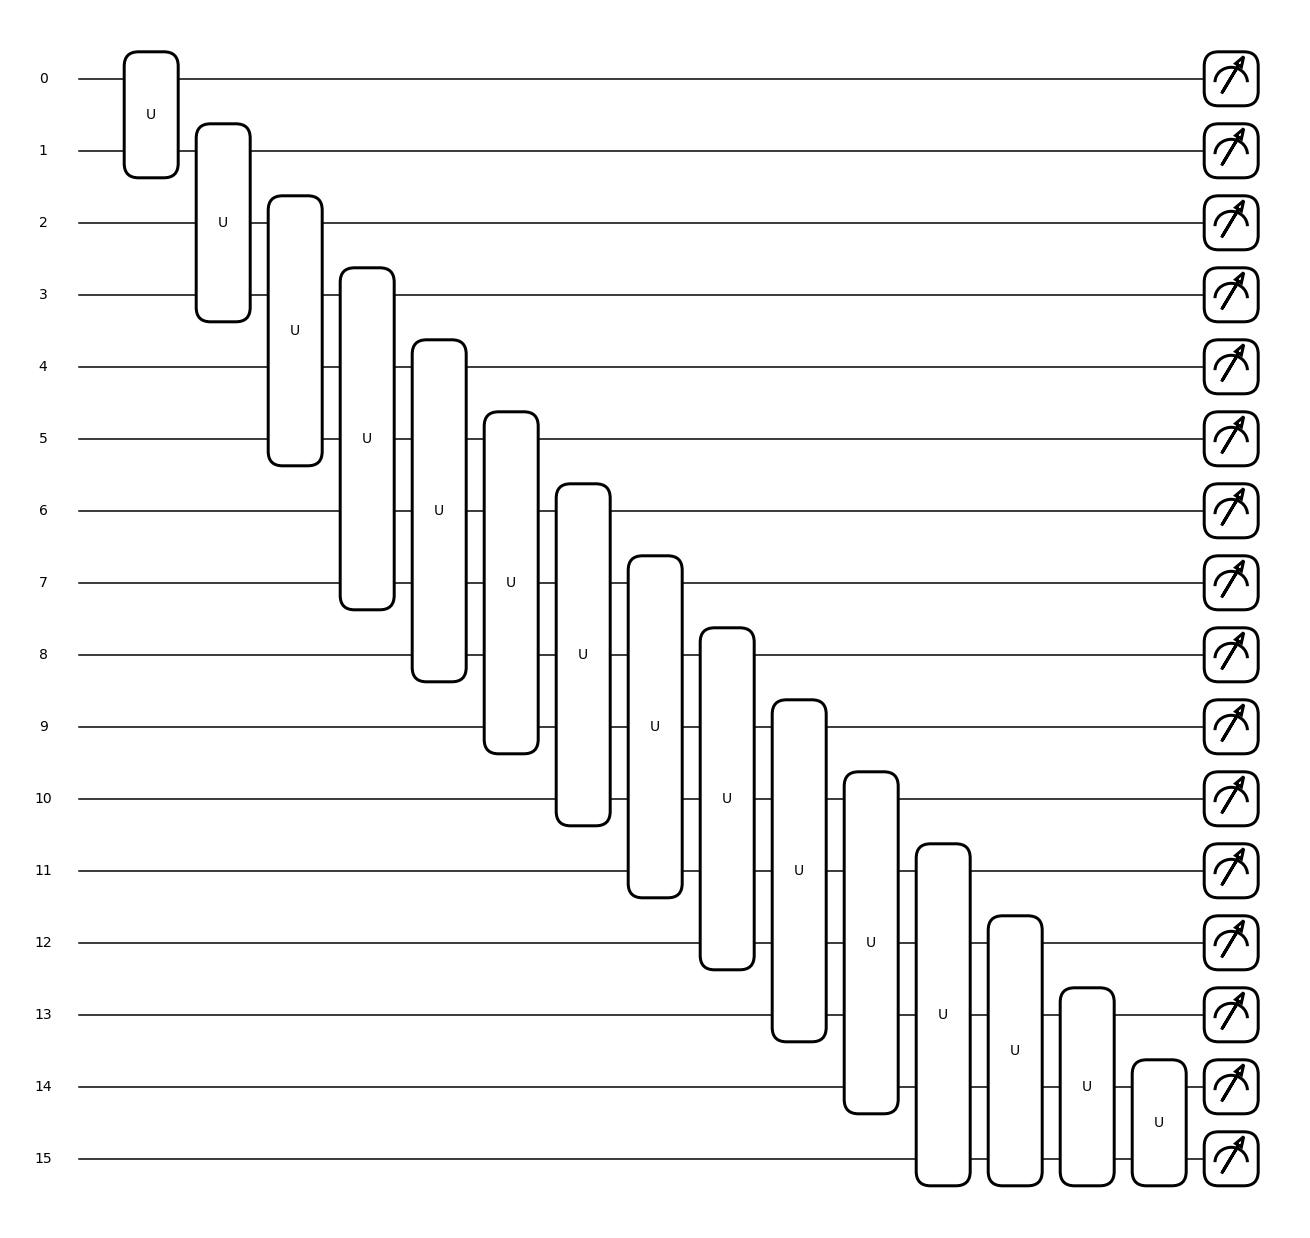

In [26]:
%autoreload
circuit = mps_circuit.mps_unitaries_to_circuit(mps_unitaries)
qml.drawer.draw_mpl(circuit)()

## Evaluate KL-divergence of the trained model

In [28]:
probs = circuit()
kl_div = metrics.kl_divergence(probs, data)
print(kl_div)

27.23705003158507


## Generate and visualize samples from the circuit

In [36]:
sampling_circuit = mps_circuit.mps_unitaries_to_circuit(mps_unitaries,
                                                        shots=10000)
samples = sampling_circuit()

## Plot the top-30 most frequent BAS samples generated by the model

Frequency : 20
Frequency : 17
Frequency : 16
Frequency : 16
Frequency : 15
Frequency : 13
Frequency : 13
Frequency : 12
Frequency : 12
Frequency : 12
Frequency : 11
Frequency : 11
Frequency : 11
Frequency : 11
Frequency : 10
Frequency : 10
Frequency : 10
Frequency : 9
Frequency : 9
Frequency : 9
Frequency : 9
Frequency : 9
Frequency : 9
Frequency : 9
Frequency : 9
Frequency : 9
Frequency : 9
Frequency : 9
Frequency : 8
Frequency : 8


(<Figure size 1296x1080 with 30 Axes>, <Axes: >)

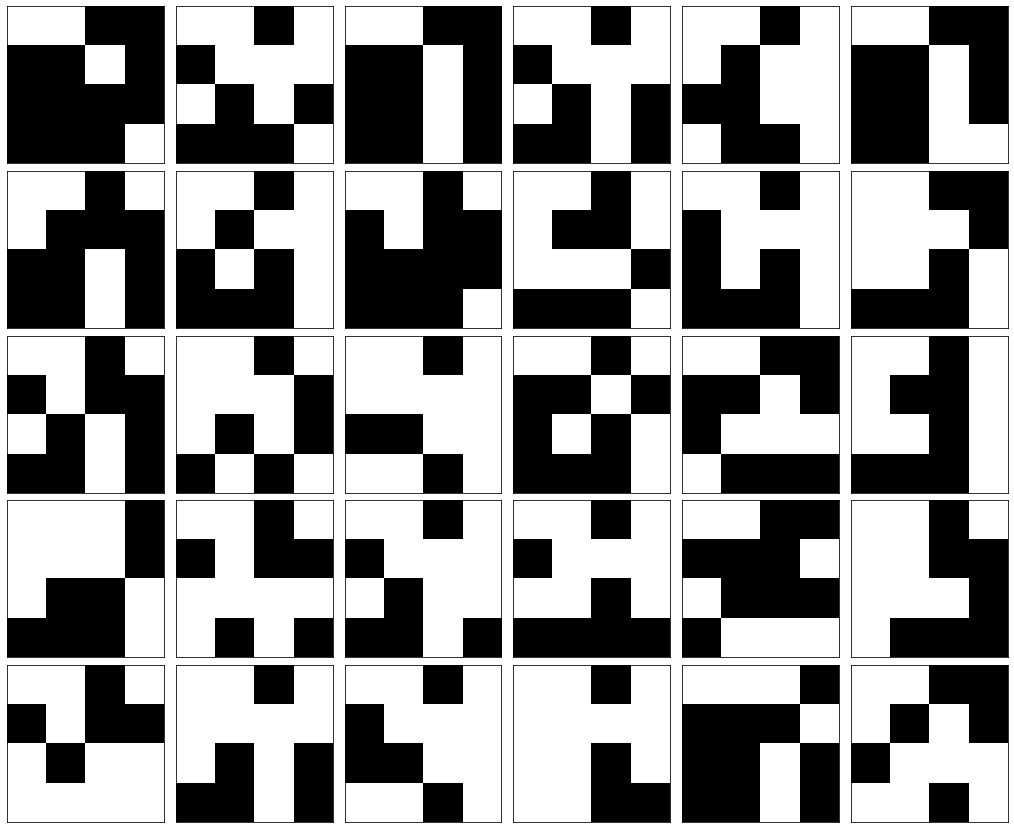

In [37]:
%autoreload
metrics.plot_top_samples(samples)

## Extend the MPS circuit with trainable parameters

In [52]:
n_qubits = 5
n_wires = 16
wire = 1
u_wires = [wire] + list(range(wire+1, wire+n_qubits))
n_wires = len(mps_unitaries) + 1
weights = pnp.random.normal(size=(45, 1), requires_grad=True)
shots = None

dev = qml.device("default.qubit", wires=n_wires, shots=shots)

@qml.qnode(dev)
def pqc_circuit(weights):

    for wire in range(n_wires-1):
        unitary = mps_unitaries[wire]
        n_qubits = int(np.log2(unitary.shape[0]))
        u_wires = [wire] + list(range(wire+1, wire+n_qubits))
        qml.QubitUnitary(unitary, wires=u_wires)

    i = 0
    while i <= n_wires-3:
        qml.RX(*weights[i], wires=i)
        qml.RX(*weights[i+1], wires=i+1)
        qml.RX(*weights[i+1], wires=i+2)
        qml.CNOT(wires=[i,i+1])
        qml.CNOT(wires=[i,i+2])
        qml.CNOT(wires=[i+1,i+2])
        i += 1
        
    # return bitstring samples if number of shots specified
    if shots is not None:
        return qml.sample()
    # else return the probs of bitstrings
    return qml.probs(wires=range(n_wires))

def loss(weights):
    data = np.load('BStest/BSdata.npy')
    data = data.astype(np.int32).reshape(-1, data.shape[1]*data.shape[2])      
    probs = pqc_circuit(weights)
    return metrics.kl_divergence(probs, data)

opt = qml.GradientDescentOptimizer(stepsize=1)

n_its = 2

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 50 == 0:
        print(_loss)
    loss_track.append(_loss)

26.558206047387586


## Extended circuit

(<Figure size 4392x1224 with 1 Axes>, <Axes: >)

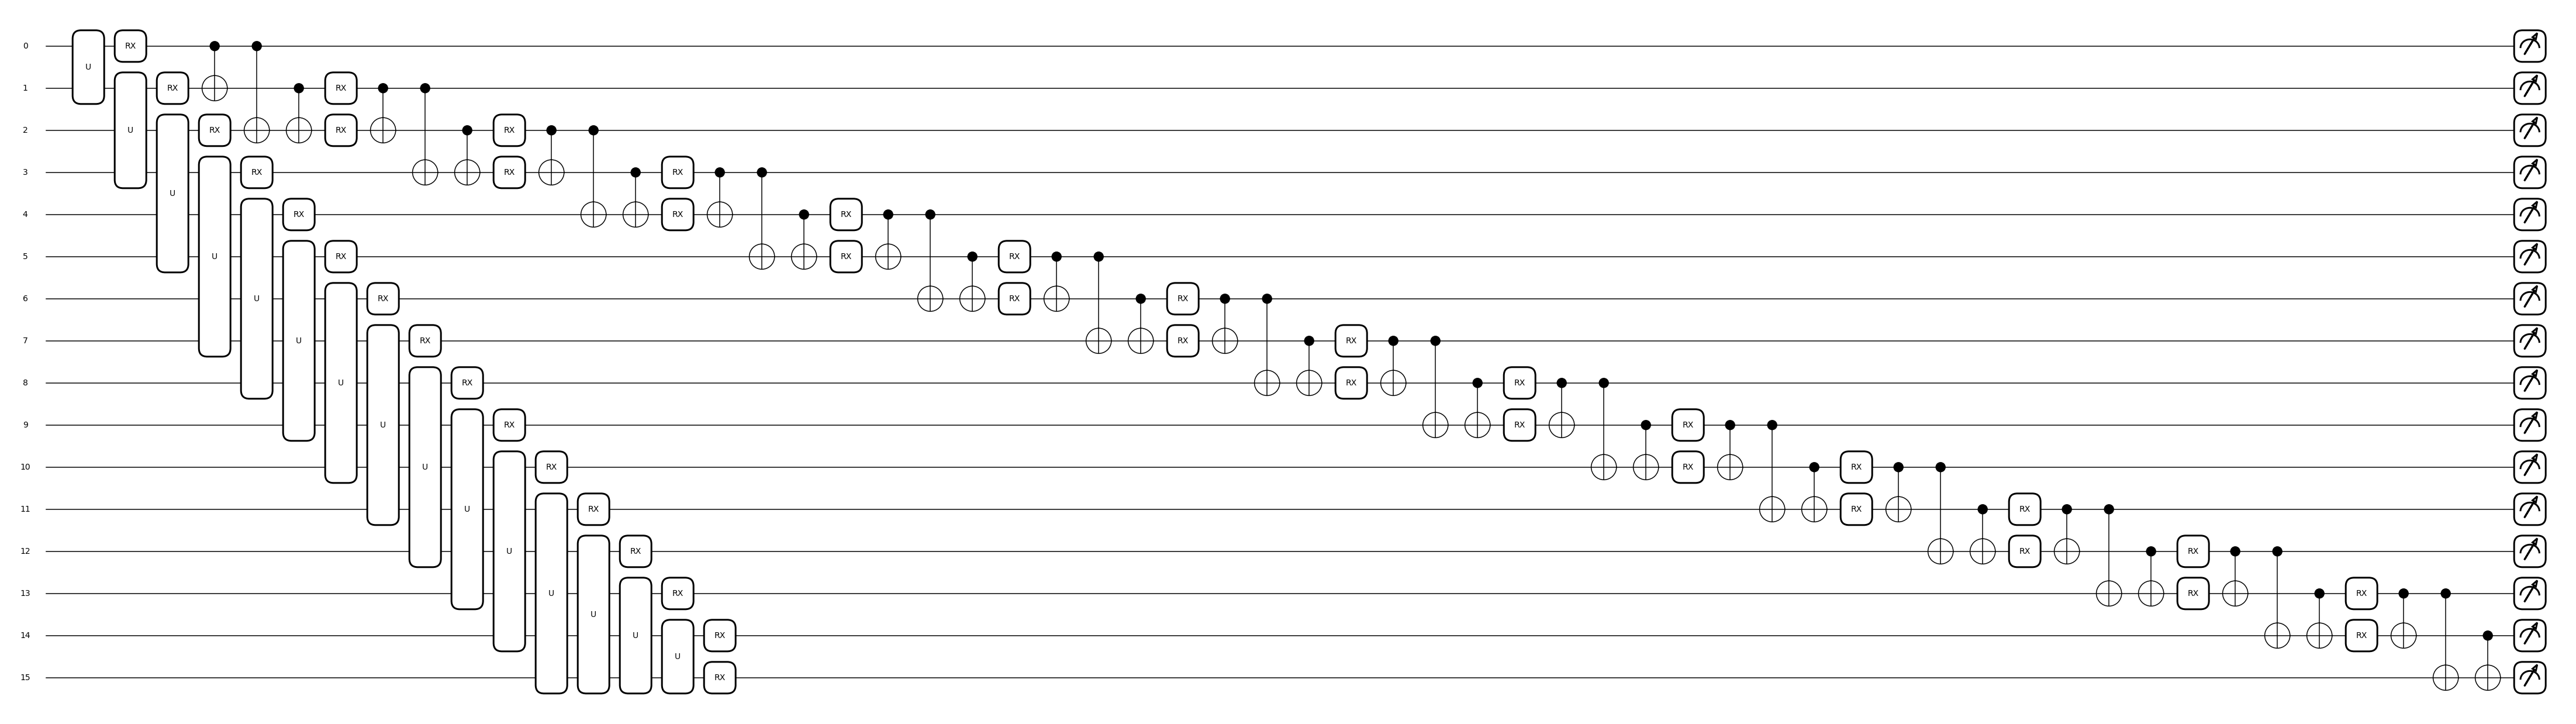

In [53]:
qml.drawer.draw_mpl(pqc_circuit)(weights)

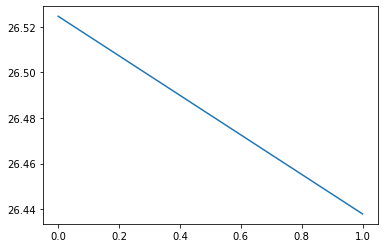

In [51]:
plt.plot(loss_track)